In [1]:
import requests
import pandas as pd
from itables import show
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from itables import show, options as opt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

#utils
from utils import y_axis_formatter

# settings
opt.maxBytes = 1000000
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_columns', None)

# Extracting data

## Sites

In [2]:
url = "https://api.mercadolibre.com/sites"
response = requests.get(url)
json_response = response.json()
df_sites = pd.DataFrame(json_response)
df_sites.head(2)

,default_currency_id,id,name
0,GTQ,MGT,Guatemala
1,NIO,MNI,Nicaragua


## Categories

In [3]:
# Site to study
site = "MLM"

url = f"https://api.mercadolibre.com/sites/{site}/categories"
response = requests.get(url)
json_response = response.json()
df_categories = pd.DataFrame(json_response)
df_categories.shape

(31, 2)

In [4]:
df_categories.head(1)

,id,name
0,MLM1747,Accesorios para Vehículos


## Items

In [5]:
# corremos unicamente si no existe el df_response
try:
    df_response = pd.read_pickle("./df_response.pkl")
    file_exists = 1
    print("File exists")
    
except Exception as e:
    print(f"No existe el file \n{e}")
    file_exists = 0
    offset = 550

    total_json_response = [] # para guardar toda la respuesta
    list_failed_requests = [] # para guardar errores

    for category in df_categories["id"].values.tolist():


        for i in range(0, offset, 50):

            clear_output(wait=True)
            category_name = df_categories[df_categories["id"] == category]["name"].values[0]
            print(f"Category_id: {category} | Category name: {category_name} | Offset: { i }")

            # Haciendo request: cubriendonos de errores
            try:
                url = f"https://api.mercadolibre.com/sites/{site}/search?category={category}&offset={i}"
                response = requests.get(url)
                new_json_response = response.json()
                
                new_json_response = [{**item, "category": category} for item in new_json_response["results"]]
                total_json_response.extend(new_json_response) # guardando nueva respuesta
            except Exception as e:
                print(f"FAILED FOR: Category_id: {category} | Category name: {category_name} | Offset: { i }")
                print(e)
                list_failed_requests.append({"category": category, "category_name": category_name, "offset": offset})

File exists


In [6]:
if file_exists == 0:
    # revisando que tipos de variables de cada item
    [[key, type(total_json_response[0][key])] for key in total_json_response[0].keys()]

In [7]:
if file_exists == 0:
    # Revisando que atributos son de tipo dict
    [[key, type(total_json_response[0][key]), len(total_json_response[0][key]) ] for key in total_json_response[0].keys()  if str(type(total_json_response[0][key])) == "<class 'dict'>"]

In [8]:
# Pasando a un dataframe
if file_exists == 0:

    df_response = pd.DataFrame(total_json_response)

    # Normalizando columnas de tipo dict
    for col in ['shipping', 'seller', 'installments']:

        # colocando prefijo a columnas
        df_normalized = pd.json_normalize(df_response[col])
        # renombrando columnas
        dict_cols = {}
        for c in pd.json_normalize(df_response[col]).columns.values.tolist():
            dict_cols[c] = f"{col.upper()}_{c}"

        df_normalized = df_normalized.rename(columns=dict_cols)

        df_response = pd.concat([df_response, df_normalized], axis=1)
        
        df_response.to_pickle("./df_response.pkl")

# Analysing data

In [9]:
df_response = pd.merge(df_response, df_categories, left_on="category", right_on="id").drop(columns="id_y").rename(columns={"name": "category_name", "id_x": "id"})

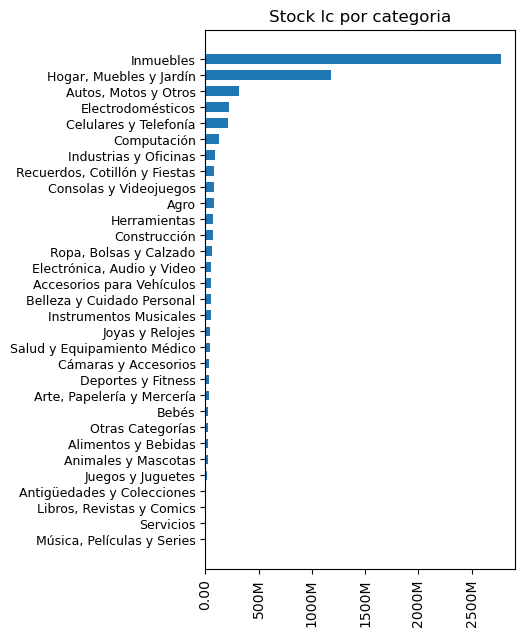

In [10]:
df = df_response.copy()
df["stock_lc"] = df_response["available_quantity"] * df_response["original_price"].combine_first(df_response["price"])


plt.figure(figsize=(4,7))

plt.title("Stock lc por categoria")
plt.barh(
    data=df.groupby("category_name").sum()["stock_lc"].reset_index().sort_values(by="stock_lc", ascending=True),
    width="stock_lc",
    y="category_name",
    height=0.6
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
plt.yticks(fontsize=9)
plt.xticks(rotation=90)
plt.show()

## Sellers especiales
- Los sellers de inmuebles, hogar, y autos probablemente deban ser tratados por separado.

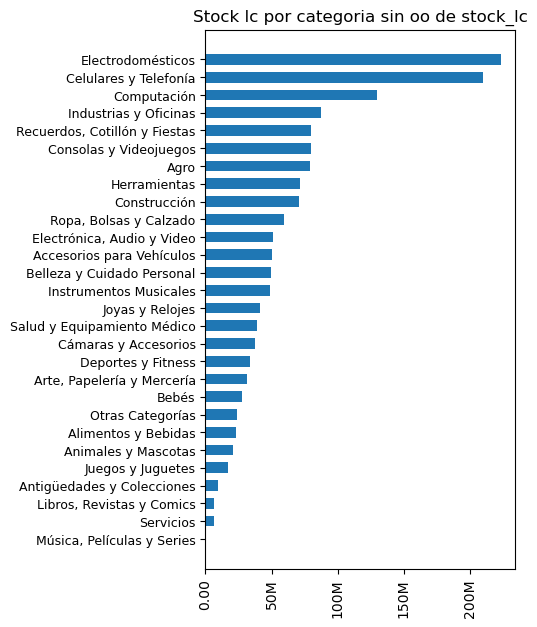

In [11]:
df = df_response[~df_response["category_name"].isin(['Inmuebles', 'Hogar, Muebles y Jardín', 'Autos, Motos y Otros'])].copy()
df["stock_lc"] = df_response["available_quantity"] * df_response["original_price"].combine_first(df_response["price"])


plt.figure(figsize=(4,7))

plt.title("Stock lc por categoria sin oo de stock_lc")
plt.barh(
    data=df.groupby("category_name").sum()["stock_lc"].reset_index().sort_values(by="stock_lc", ascending=True),
    width="stock_lc",
    y="category_name",
    height=0.6
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
plt.yticks(fontsize=9)
plt.xticks(rotation=90)
plt.show()

In [12]:
# removiendo columnas que no queremos
df_response.drop(columns = ["thumbnail_id", "permalink", "thumbnail", "official_store_id", "use_thumbnail_id",
                            "shipping", "stop_time", "seller", "attributes", "installments", "differential_pricing",
                            "SHIPPING_tags", "SHIPPING_shipping_score", "SHIPPING_promise", "SHIPPING_mode", "INSTALLMENTS_amount",
                            "INSTALLMENTS_rate", 
                            
                           ], inplace=True, axis=1)

In [13]:
df_response.head(1)

,id,title,condition,catalog_product_id,listing_type_id,buying_mode,site_id,category_id,domain_id,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_name,accepts_mercadopago,winner_item_id,catalog_listing,discounts,promotions,inventory_id,category,variation_filters,variations_data,location,seller_contact,SHIPPING_store_pick_up,SHIPPING_free_shipping,SHIPPING_logistic_type,SHIPPING_benefits,SELLER_id,SELLER_nickname,INSTALLMENTS_quantity,INSTALLMENTS_currency_id,category_name
0,MLM1923930303,Xiaomi 70mai 1s 1080p Camara Dvr Auto Dash Sma...,new,MLM23492063,gold_pro,buy_it_now,MLM,MLM429390,MLM-VEHICLE_CAMERAS,MXN,1,904.20,"1,644.00",None,250,70mai,True,None,True,None,[],LWMT87970,MLM1747,NaN,NaN,NaN,NaN,False,True,cross_docking,None,646241193,TEKSHOP MX,3.00,MXN,Accesorios para Vehículos


## Potenciales variables de entrada:
- **categories_participation**: Participacion del seller en diferentes categorias
- **stock_lc**: Stock total valuado (mxn)
- **stock_units**: Stock total en unidades
- **items**: Publicaciones totales
- **condition_new**: Publicaciones en condicion nueva
- **condition_used**: Publicaciones en condicion usada
- **discount_perc**: Porcentaje promedio de descuento
- **weighted_mapped_listing_type**: Tipo de publicacion ponderada por stock valuado
    - gold_premium: 3
    - gold_pro: 2
    - gold_special: 1
- **average_price**: Precio promedio de las publicaciones

In [14]:
# Preparando columnas para hacer calculos

# eliminando precios en null
df_response.dropna(subset="price", inplace=True)
# coalesce entre original_price y price
df_response["original_price"] = df_response["original_price"].combine_first(df_response["price"])

# calculando porcentaje de descuento
df_response["discount_perc"] = round((df_response["original_price"] - df_response["price"] ) / df_response["original_price"], 2)

# stock valuado
df_response["stock_lc"] = df_response["available_quantity"] * df_response["price"]

# Dropeando nulos en condition y los not specified
df_response.dropna(subset="condition", inplace=True)
df_response = df_response[df_response["condition"] != "not_specified"]

# agregando variable dummy para condicion
df_response = pd.concat([df_response, pd.get_dummies(df_response["condition"], prefix="condition")], axis=1).drop(columns="condition")

# mappeando listing type a valores numericos
df_response["mapped_listing_type"] = df_response["listing_type_id"].map({"gold_premium": 3, "gold_pro": 2, "gold_special": 1})

# Agregando stock total del seller: para ponderar el mapped_listing_type
df_response["stock_total_seller_lc"] = df_response.groupby("SELLER_nickname")["stock_lc"].transform(np.sum)

# weighted mapped_listing_type por stock_lc
df_response["weighted_mapped_listing_type"] = df_response["mapped_listing_type"] * (df_response["stock_lc"] / df_response["stock_total_seller_lc"])

#### Vars

In [15]:
df_in = df_response.groupby("SELLER_nickname").aggregate(
    {
        "category_name": "nunique",
        "stock_lc": "sum",
        "available_quantity": "sum",
        "id": "nunique",
        "condition_new": "sum",
        "condition_used": "sum",
        "discount_perc": "mean",
        "weighted_mapped_listing_type": "sum"
    }).reset_index()

df_in["average_price"] = round(df_in["stock_lc"] / df_in["available_quantity"], 2)
df_in["discount_perc"] = df_in["discount_perc"] * 100
df_in["condition_used"] = 100 * (df_in["condition_used"] / df_in["id"])

# Renombando variables
df_in.rename(columns={
    "category_name": "categories_participation",
    "available_quantity": "stock_units",
    "id": "items"
}, inplace=True)



## Outliers

### Análisis de outliers
- En la variable stock_lc, tenemos outliers que sesgan el analisis y hacen que los sellers se concentren en un solo cluster. Por lo que favorece al análisis eliminarlos.

- **stock_lc por cluster sin remover outliers**
<img src="./images/stock_lc_with_oo.png" width="30%" height="30%"/>

- **Resumen de clusters**
<img src="./images/summary_clusters_with_oo.png" width="70%" height="70%"/>

- Cuando no excluimos outliers, el modelo, aunque si esta clasificando por valor de stock, esta priorizando otras variables como:
    - items_mean: Cantidad de publicaciones
    - condicion: usado/nuevo
    - porcentaje de descuento
    - tipo de publicacion: gold, gold_premium, etc

- Aunque esas otras variables son importantes, es más relevante para el negocio, tener productos con alta rotación, donde podemos operar warehousing y transporte.
- En los clusters uno y dos tenemos productos como inmuebles o autos (baja rotacion, muy elevado ASP), mientras que en el cluster 0 tenemos productos de alta rotación con ASP mas bajo, donde podemos explotar potencial operación.
- Por lo tanto, se excluyen aquellos productos de alto ASP, donde la estrategía podría ser incentivos por publicidad.

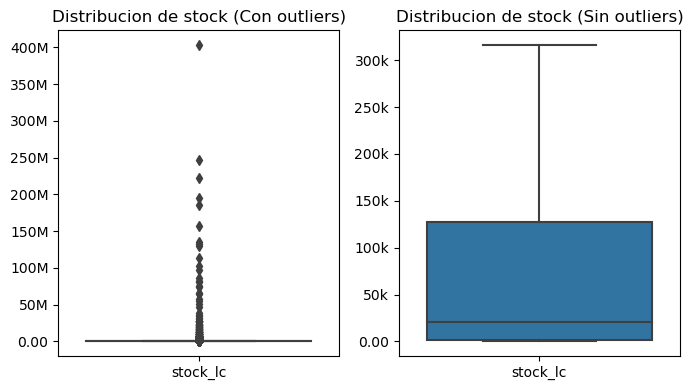

In [16]:
plt.figure(figsize=(7, 4))  # Create a figure with a specified size

# First boxplot
plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st subplot)
plt.title("Distribucion de stock (Con outliers)")
sns.boxplot(data=df_in[["stock_lc"]], showfliers=True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

# Second boxplot
plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd subplot)
plt.title("Distribucion de stock (Sin outliers)")
sns.boxplot(data=df_in[["stock_lc"]], showfliers=False)
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

### Eliminando outliers

In [17]:
# calculando outliers por stock_lc
quantiles = df_in["stock_lc"].quantile([0, 0.25, 0.5, 0.75, 1])
outlier_threshold = 2 * (quantiles[0.75] - quantiles[0.25])
# Eliminando los outliers
df_in_no_oo = df_in[df_in["stock_lc"] <= outlier_threshold].copy()
#df_in_no_oo = df_in.copy()

## Descartando variables
- **condition_new:** Es redundante con condition used

- **condition_used:** No influye en la decisión del modelo, ya que hay muy pocas publicaciónes en condition_used
<img src="./images/condition_used_cluster_out.png" width="30%" height="30%"/>

- **stock_units:** Hay una alta correlacion entre stock en unidades y mxn, con lo cual, agregar la variable puede resultar redundante. Al subir el stock en unidades, sube tambien el stock en mxn
<img src="./images/stock_units_and_lc_correlation.png" width="40%" height="40%"/>

- **weighted_mapped_listing_type:** La variable no tiene influencia en la clusterización, la mayoría de los sellers tienen los mismos tipos de publicación. Al retirar la variable, los clusters se mantienen iguales.
<img src="./images/tipo_de_publicacion.png" width="30%" height="30%"/>

#### PCA

- La varianza acumulada nos dice que con las primeras dos PC se puede explicar el dataset.
- La matriz de varianzas por componente nos indica que:
    - La variable que mejor explica el dataset es el stock_lc
    - Seguido de average_price en PC2
    - Seguido de stock_units (esta se descarta por la correlación positiva que tiene con stock_lc)
    - Seguido de descuento en PC4

In [18]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X = df_in_no_oo.values[:,1:] # generando matriz de variables de entrada
Clus_dataSet = StandardScaler().fit_transform(X)

In [19]:
from sklearn.decomposition import PCA
# Calculando PCA
pca = PCA().fit(X)

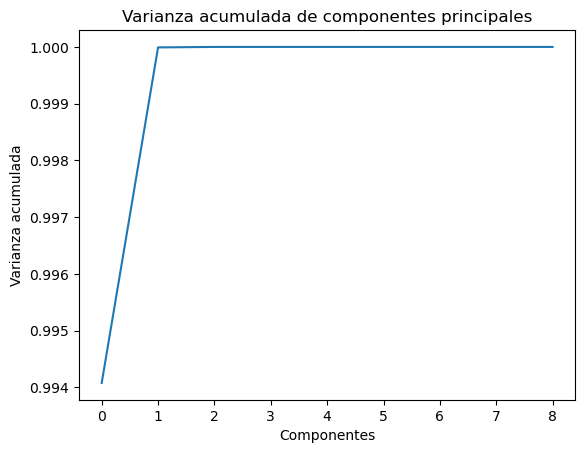

In [20]:
# array de varianza
array_varianza = pca.explained_variance_ratio_
# suma acumulada
array_varianza = np.cumsum(array_varianza)

plt.plot(array_varianza)
plt.title("Varianza acumulada de componentes principales")
plt.xlabel("Componentes")
plt.ylabel("Varianza acumulada")
plt.show()

In [21]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=['categories_participation', 'stock_lc',
                                                                                                    'stock_units', 'items', 'condition_new', 
                                                                                                    'condition_used',
                                                                                                    'discount_perc', 'weighted_mapped_listing_type', 'average_price'])
loadings_df.reset_index().rename(columns={"index": "var"})

,var,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,categories_participation,0.20,-0.05,0.18,-0.03,0.13,-0.00,0.69,0.03,-0.03
1,stock_lc,"56,620.49",-12.83,-0.48,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
2,stock_units,161.58,-31.89,165.15,-0.27,-0.03,-0.01,-0.00,0.00,0.00
3,items,0.83,-0.12,0.53,-0.61,4.64,0.24,-0.07,-0.01,-0.15
4,condition_new,0.87,-0.19,0.54,-0.64,4.67,0.17,0.05,0.01,0.15
5,condition_used,0.14,5.00,0.39,0.06,-0.34,5.49,0.00,-0.00,0.00
6,discount_perc,3.48,-1.71,2.56,17.73,0.33,-0.00,0.00,-0.00,0.00
7,weighted_mapped_listing_type,0.00,0.11,-0.03,0.07,-0.02,0.05,-0.05,0.47,-0.00
8,average_price,167.55,"4,366.88",1.21,0.00,0.00,-0.01,0.00,-0.00,0.00


#### Droppeando variables

In [22]:
# droppeando columnas innecesarias
dropped_columns = [
    "stock_units", 
    "condition_new",
    "condition_used",
    "weighted_mapped_listing_type",
    #"average_price",
    "categories_participation",
]
df_in_no_oo.drop(columns=dropped_columns, inplace=True)

### Matriz de correlaciones
- Para eliminar variables redundantes

<AxesSubplot:>

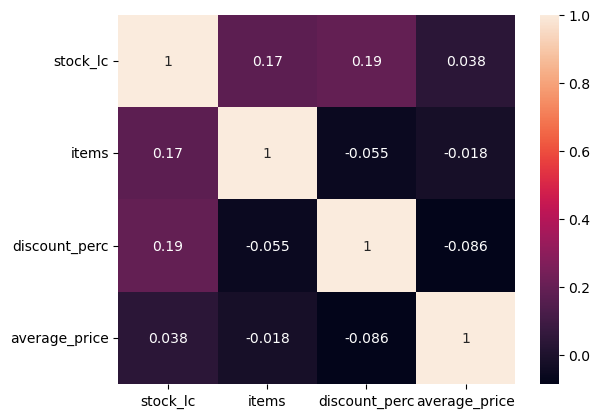

In [23]:
sns.heatmap(df_in_no_oo.corr(), annot=True)

# Creando modelo

##  Estandarizando data

In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X = df_in_no_oo.values[:,1:] # generando matriz de variables de entrada
Clus_dataSet = StandardScaler().fit_transform(X)

## Modelando

### Definiendo no. de clusters: Elbow method

- Distorsión: la suma de las distancias cuadras de cada punto a su centroide.
- Nos ayuda a definir cuantos clusters seleccionar.
- Ve la distancia de cada punto a cada centroide del cluster.
- El número óptimo de clusters es el punto de inflexión en el que la pendiente decrece (elbow).
- En este caso el punto óptimo es 3 clusters


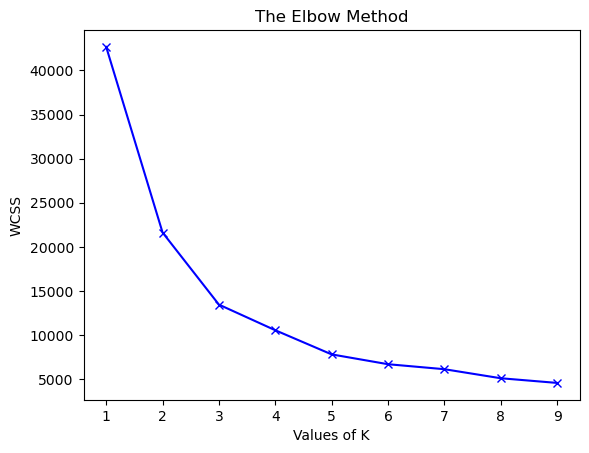

In [25]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist



distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X.astype("float"), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X.astype("float"), kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('WCSS')
plt.title('The Elbow Method')
plt.show()

### Modelo

In [26]:
# inicializando modelo
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)

In [27]:
# ajustando modelo
k_means.fit(X)
k_means_labels = k_means.labels_

In [28]:
df_in_no_oo["clusters"] = k_means_labels

## Analisis de resultados

### Items por clusters

In [50]:
# absoluto
sellers_por_cluster = df_in_no_oo["clusters"].value_counts().reset_index().rename(columns={"index": "cluster", "clusters":"sellers"})

# porcentual
sellers_por_cluster = pd.concat([sellers_por_cluster, df_in_no_oo["clusters"].value_counts(normalize=True) * 100], axis=1)
sellers_por_cluster.rename(columns={"clusters": "perc"})

,cluster,sellers,perc
0,0,2803,70.93
1,1,767,19.41
2,2,382,9.67


### Promedios por variable

In [59]:
# calculando medias
df_summary = df_in_no_oo.groupby("clusters").mean().reset_index()

# renombrando columnas de promedios
for c in df_summary.columns.values.tolist()[1:]:
    df_summary.rename(columns={f"{c}": f"{c}_mean"}, inplace=True)
    
# concatenando
df_summary = pd.concat([df_in_no_oo.groupby("clusters").count()["items"], df_summary], axis=1).rename(columns={"items": "sellers_count"})

# Agregando clusters a df_in
df_response_clustered = pd.merge(df_response, df_in_no_oo[["SELLER_nickname", "clusters"]], on="SELLER_nickname")

# reordenando columnas
cols = df_summary.columns.values.tolist()
new_order = [cols[1]]
new_order.extend([cols[0]])
new_order.extend(cols[2:])

df_summary = df_summary[new_order]

# redondeando
round(df_summary["stock_lc_mean"], 0)

df_summary

,clusters,sellers_count,stock_lc_mean,items_mean,discount_perc_mean,average_price_mean
0,0,2803,"7,842.49",1.90,8.72,"1,067.73"
1,1,767,"75,602.35",3.09,16.28,"1,352.93"
2,2,382,"180,582.61",4.15,17.38,"1,214.53"


In [32]:
# Revisando un seller
#show(df_response[df_response["SELLER_nickname"] == "KARZOV"])

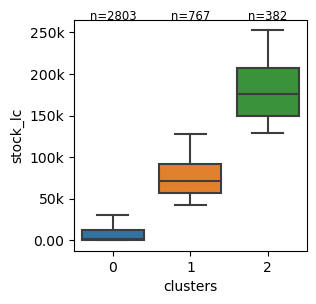

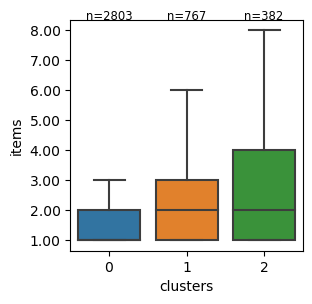

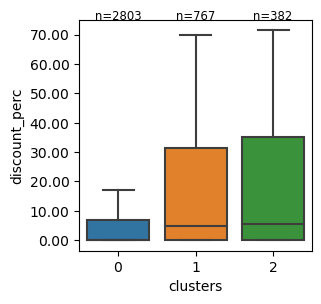

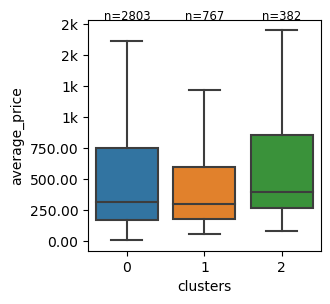

In [212]:
for c in df_in_no_oo.columns.values.tolist()[1:-1]:
    plt.figure(figsize=(3, 3))
    ax = sns.boxplot(data=df_in_no_oo, x="clusters", y=c, showfliers=False)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    # Adding count annotations
    cluster_counts = df_in_no_oo['clusters'].value_counts().sort_index()
    for i, count in enumerate(cluster_counts):
        ax.text(i, ax.get_ylim()[1], f'n={count}', horizontalalignment='center', size='small', color='black')

    plt.show()

In [ ]:
df11=df.groupby('key1')['key2'].apply(lambda x: (x=='one').sum()).reset_index(name='count')
print (df11)

In [156]:
df_response_clustered["SELLER_nickname"].nunique()

3952

In [163]:
flt = df_response_clustered["clusters"] == 0

#df_response["clus"]
pd.concat(
    [df_response_clustered, pd.get_dummies(df_response_clustered["clusters"], prefix="C", prefix_sep="")],
    axis=1
).groupby("category_name").sum()[["C0", "C1", "C2"]]


sellers_por_cluster = pd.concat(
    [
        df_response_clustered[df_response_clustered["clusters"] == 0].groupby("category_name")["SELLER_nickname"].nunique().reset_index(),
        df_response_clustered[df_response_clustered["clusters"] == 1].groupby("category_name")["SELLER_nickname"].nunique().reset_index().iloc[::,1],
        df_response_clustered[df_response_clustered["clusters"] == 2].groupby("category_name")["SELLER_nickname"].nunique().reset_index().iloc[::,1]
    ],
    axis=1
).fillna(0)
sellers_por_cluster.columns = ["category_name", "C0", "C1", "C2"]
sellers_por_cluster["C2"] = sellers_por_cluster["C2"].astype("int")
show(sellers_por_cluster)




#[["category_name", "clusters"]]
#.unique()

In [221]:
df_response_clustered[df_response_clustered["clusters"] == 2]["SHIPPING_logistic_type"].value_counts().reset_index()

,index,SHIPPING_logistic_type
0,fulfillment,1261
1,cross_docking,202
2,xd_drop_off,163
3,drop_off,19
4,not_specified,2
5,custom,1
6,default,1


In [223]:
df_response_clustered["title"] = df_response_clustered["title"].str.slice(0,40)
show(df_response_clustered[df_response_clustered["clusters"] == 2][["SELLER_nickname", "title", "category_name", "available_quantity", "stock_lc", "price", "SHIPPING_logistic_type"]])